In [1]:
from fastai2.vision.all import *
from faststyle import *

In [2]:
source = Path('/home/lgvaz/.data/cats')

In [3]:
class RandomErasingX(RandomErasing):
  split_idx=None
  def encodes(self, x:TensorImage):  return x
  def encodes(self, x:TensorImageX): return super().encodes(x)

In [4]:
dblock = DataBlock((ImageBlock(PILImageX), ImageBlock),
                   get_items=get_image_files, splitter=RandomSplitter(.1),
                   item_tfms=[Resize(256)],
                   batch_tfms=[RandomErasingX(p=.8), NormalizeX.from_stats(*imagenet_stats)],
                  )

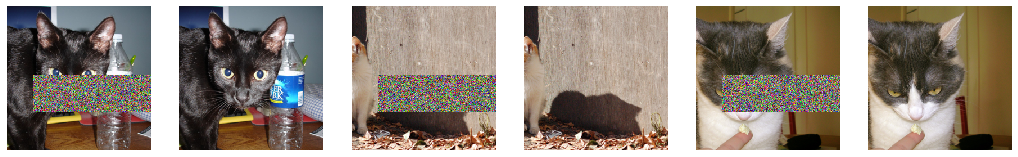

In [6]:
dls = dblock.dataloaders(source, bs=8); dls.c = 3
dls.show_batch(max_n=3)

In [7]:
feat_m = prepare_feat_model(vgg16_bn(True).features)
get_fts = LayerFeats(feat_m, stl_ls=[], cnt_ls=get_layers(feat_m, [12,22,32]),
                     tfms=NormalizeAll.from_stats(*imagenet_stats))

In [8]:
cnt_loss = partial(content_loss, layer_ws=[5,15,2])
loss_func = SuperResLoss(cnt_loss=cnt_loss)

In [9]:
cbs = [FeatsCallback(get_fts)]
metrics = loss_func.metrics
cfg = unet_config(blur=True, self_attention=True, norm_type=NormType.Weight, y_range=(0.,1.))
learn = unet_learner(dls=dls, arch=resnet34, loss_func=loss_func, cbs=cbs,
                     metrics=metrics, config=cfg)

In [ ]:
learn.lr_find()

In [15]:
learn.load('inpainting_cats')

In [ ]:
learn.fit_one_cycle(3, 1e-3, pct_start=.9)

epoch,train_loss,valid_loss,pixel,cnt,time


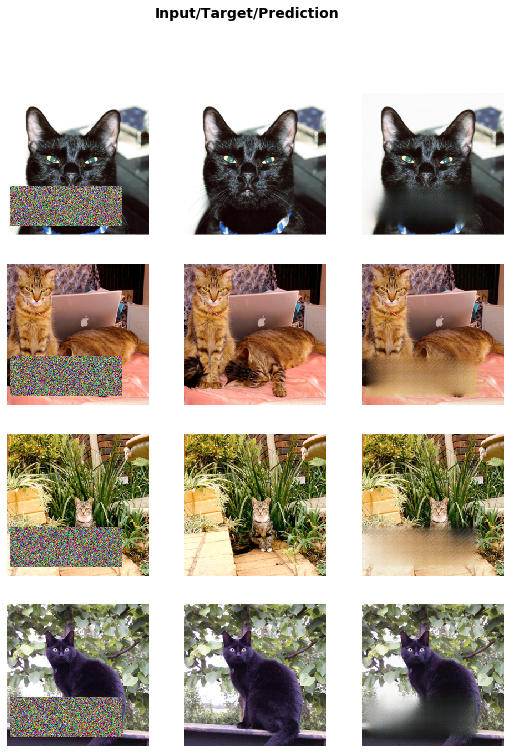

In [17]:
learn.show_results()